In [80]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v2.enable_v2_behavior()
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
%matplotlib inline

In [281]:
#define input parameters
number_of_points = 100;
noise_variance = 0.1;
frequency = 1.5;

In [282]:
#Create a sinusoidal wave 

def sinusoid_wave(x,frequency):
    generated_wave = np.sin((frequency*2)*np.pi*x[...,0]);
    return generated_wave

In [283]:
#create sampling points and noisy observations

#random uniform distribution of sampling points between -1 and 1
random_points = np.random.uniform(low=-1., high=1., size=(number_of_points,1)).astype(np.float64);

#output wave is sinusoid + noise
output_wave = sinusoid_wave(random_points, frequency) + np.random.normal(
    loc=0, scale=(noise_variance**(1/2)), size=number_of_points)

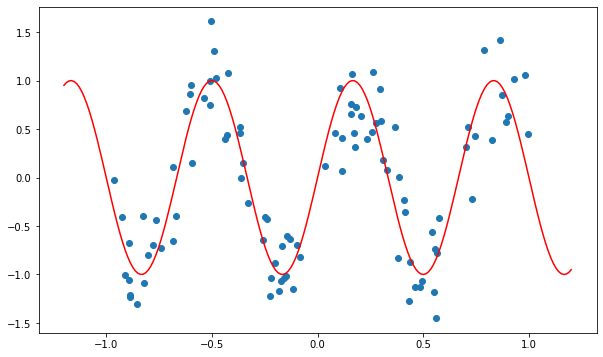

In [284]:
#plot observations and the base signal
x_line = np.linspace(-1.2,1.2,num=200).reshape(200,1)
plt.figure(figsize=(10,6))
plt.scatter(random_points, output_wave)
plt.plot(x_line,sinusoid_wave(x_line, frequency), 'r')

In [285]:
#Function which will be called to create a GP model
#Several values for the input parameters will be tried to build an optimum model

def build_gp_model(amplitude, length_scale, observation_noise_variance):
    
    model_kernel = tfk.ExponentiatedQuadratic(amplitude = amplitude, length_scale = length_scale)
    #Exponentiated Quadratic
    #model_kernel = (amplitude**2) * np.exp(-(np.linalg.norm(x-y)**2) / (2 * length_scale**2))
    
    return tfd.GaussianProcess(
      kernel = model_kernel,
      index_points = random_points,
      observation_noise_variance = observation_noise_variance)

In [286]:
#generate a joint distribution of model parameters
#several values for each parameter will be generated and we will sample
#from the distribution to find a selection of values that will minimize error

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp_model,
})

In [287]:
#Sample a value for each parameter from the joint distribution
#gp model is created using those 
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=2.14303326631256>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=1.0979713048189383>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=4.10749426488864>, 'observations': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([-0.2200737 , -3.16217969, -2.97241864, -3.1697803 , -2.28112236,
        0.63031891, -0.90496586, -6.59022973, -2.84934908, -2.90201095,
        0.01009803, -2.33882373, -4.80852044,  2.02945178, -2.63432247,
        0.73223766, -2.9767927 , -2.00180122,  0.51236702, -3.65445743,
       -2.34132357, -2.97958177, -4.23923353, -1.52716855,  0.23306803,
       -2.90177501, -3.32624569, -0.30323746, -5.27682239, -3.86747688,
       -3.32122407, -3.69515924, -5.04597883, -2.29463182, -1.49782203,
       -0.70881437, -4.49500351, -1.8395538 , -4.43629848, -5.13381022,
        0.1500987 , -2.51942764,  0.90543575, -0.55428973, -4.87832219,
       -3.56318011, -6.96485964,

In [288]:
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

In [289]:
amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]

In [290]:
trainable_variables

[<tf.Variable 'amplitude:0' shape=() dtype=float64, numpy=0.0>,
 <tf.Variable 'length_scale:0' shape=() dtype=float64, numpy=0.0>,
 <tf.Variable 'observation_noise_variance_var:0' shape=() dtype=float64, numpy=0.0>]

In [291]:
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale, observation_noise_variance):
    return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': output_wave
  })

In [292]:
num_iters = 200
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    with tf.GradientTape() as tape:
        loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.8608864764448524
length_scale: 0.18478850818247425
observation_noise_variance: 0.13832976699875904


Text(0, 0.5, 'Log marginal likelihood')

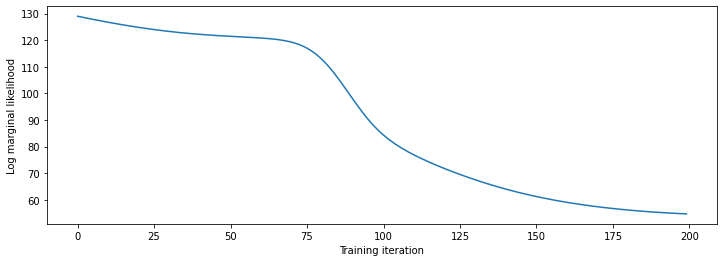

In [293]:
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")

In [294]:
#predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
#predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel = optimized_kernel,
    index_points = x_line,
    observation_index_points = random_points,
    observations = output_wave,
    observation_noise_variance = noise_variance,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

Text(0, 0.5, 'Observation space')

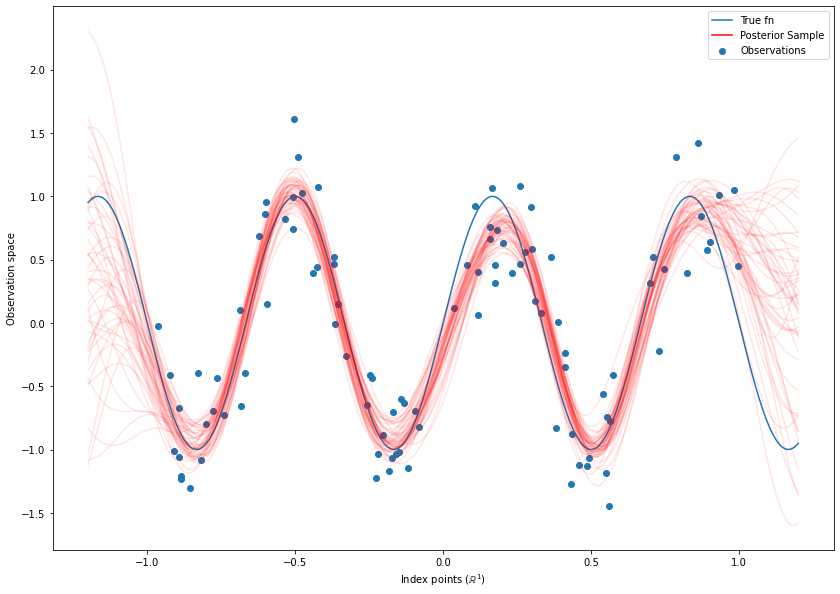

In [295]:
plt.figure(figsize=(14, 10))
plt.plot(x_line, sinusoid_wave(x_line, frequency),
         label='True fn')
plt.scatter(random_points[:, 0], output_wave,
            label='Observations')
for i in range(num_samples):
    plt.plot(x_line, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")

In [296]:
mean_line = np.mean(samples[:,17:183], axis=0)

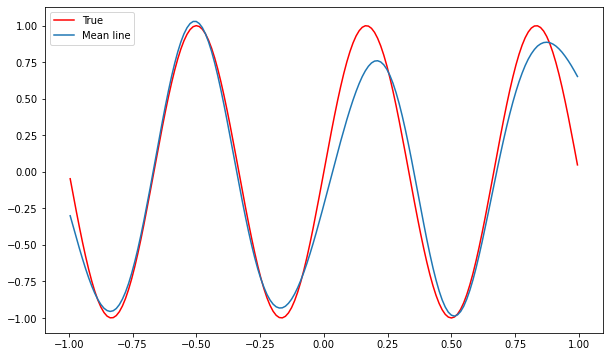

In [297]:
y_true = sinusoid_wave(x_line[17:183,:], frequency)

plt.figure(figsize=(10,6))
#plt.scatter(random_points, output_wave)
plt.plot(x_line[17:183,:],y_true, 'r', label = 'True')
plt.plot(x_line[17:183,:], mean_line, label = 'Mean line')
plt.legend()

In [278]:
RMSE = tf.keras.metrics.RootMeanSquaredError()

In [299]:
RMSE.update_state(y_true, mean_line)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=498.0>

In [280]:
RMSE.result().numpy() #1000 obs

0.026016882

In [300]:
RMSE.result().numpy() #100 obs

0.13292396